# What Is the Relationship between Housing Characteristics and Complaints?

The goal of this exercise is to find the answer to the Question 3 of the problem statement: 

> Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

In this exercise, we shall use the 311 dataset in combination with the PLUTO data set. The latter shall be used for the most problematic borough that was identified as a part of answering the Question 2. 
Remember that, the answer to Question 1 (What Is the Top Complaint Type?) was: 

> The most often reported complaint is 'HEAT/HOT WATER'

The answe to Question 2 (What Areas Should the Agency Focus On?) was:

> The borough with the most 'HEAT/HOT WATER' complaints is 'BRONX'

Therefore, in the remainder we shall analyze whether the 'HEAT/HOT WATER' comlaints reported in 'BRONX' have obvious relationship with any particular house characteristics.

# The data sets
The 311 dataset is already well known to us as it was used to answer Questions 1 & 2, therefore it does not require any special introduction. 

The PLUTO data set is new to us and it aggregates condominium unit tax lot informationto the billing lot.
The initially recommended (by the course advisers) PLUTO data set fields to consider are:

|    Field   |                  Description                     |
|------------|--------------------------------------------------|
| Address    | An address of the tax lot |
| BldgArea   | The total gross area in square feet |
| BldgDepth  | The building’s depth, measured in feet |
| BuiltFAR   | The build floor area ration |
| CommFAR    | The maximum allowable commercial floor area ratio |
| FacilFAR   | The maximum allowable community facility floor area ratio |
| Lot        | The one to four-digit tax lot number |
| LotArea    | Total area of the tax lot, in square feet |
| LotDepth   | The tax lot's depth measured in feet |
| NumBldgs   | The number of buildings on the tax lot |
| NumFloors  | The number of full and partialstories starting from the ground floor, for the tallest building on the tax lot |
| OfficeArea | An estimate of theexterior dimensions of the portion of the structure(s) allocated for office use |
| ResArea    | An estimate of the exterior dimensions of the portion of the structure(s) allocated for residential use |
| ResidFAR   | The maximum allowable residential floor area ratio |
| RetailArea | An estimate of the exterior dimensions of the portion of the structure(s) allocated for retail use |
| YearBuilt  | The year construction of the building was completed |
| YearAlter1 | Is the year of the building's most recent alteration |
| ZipCode    | A ZIP code that is valid for one of the addresses assigned to the tax lot |
| XCoord     | The X coordinate of the XY coordinate pair which depicts the approximate location of the lot |
| YCoord     | The Y coordinate of the XY coordinate pair which depicts the approximate location of the lot |

Consider reading the [PLUTO Data Dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v2) for more details. The data set archive consists of several CSV files, each devoted to a single borough:

|   CSV file  |      Borough       |
|-------------|--------------------|
| QN_18v1.csv | QUEENS |
| BK_18v1.csv | BROOKLYN |
| SI_18v1.csv | STATEN ISLAND |
| BX_18v1.csv | BRONX |
| MN_18v1.csv | MANHATTAN |

Since we are interested in borough *'BRONX'* we shall use the data from the corresponding *'BX_18v1.csv'* file.


# Load the data


Loading of the data can be done both from the IBM cloud storage and the locally present CSV files. The latter is decided upon the presence of the proper secure field values of the credentials:

In [1]:
import os
import re
import seaborn
import ibm_boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

In [2]:
# @hidden_cell
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}
bx_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BX_18v1.csv'
}

In [3]:
# Allows to get the data source for the credentials from the IBM cloud or local csv file 
def get_data_source(credentials) :
    '''Creates a data source from the IBM cloud or local csv file according to the credentials'''
    # Here we check if the credentials are present, if not try 
    # load the local file if they are then read from the cloud.
    if credentials.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
        # This is the alternative to get the code run locally with a local csv file
        body = 'data' + os.path.sep + credentials.get('FILE')
    else :
        client = ibm_boto3.client(
            service_name = 's3',
            ibm_api_key_id = credentials.get('IBM_API_KEY_ID'),
            ibm_auth_endpoint = credentials.get('IBM_AUTH_ENDPOINT'),
            config = Config(signature_version='oauth'),
            endpoint_url = credentials.get('ENDPOINT'))

        body = client.get_object(
            Bucket = credentials.get('BUCKET'),
            Key = credentials.get('FILE'))['Body']

        # add missing __iter__ method, so pandas accepts body as file-like object
        def __iter__(self): return 0
        if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    return body

Further, we shall subsequently load the 311 and PLUTO data sets. Along the way, we will select the necessary columns and check on (, and correct if needed,) the column data types.

## The 311 data set
Here we first load the 311 data set:

In [4]:
# Get the data source for the credentials
dhp_ds = get_data_source(erm2_nwe9_creds)

# Read the CSV file
dhp_df = pd.read_csv(dhp_ds, parse_dates = ['created_date', 'closed_date'])

Next, we select the data related to the comlaints reported in 'BRONX'.

In [5]:
print('Number of all complaints:', dhp_df.shape[0])
dhp_df = dhp_df[(dhp_df['borough'] == 'BRONX')]
print('Number of \'HEAT/HOT WATER\' complaints in \'BRONX\':', dhp_df.shape[0])

Number of all complaints: 6034470
Number of 'HEAT/HOT WATER' complaints in 'BRONX': 1623174


Next, let us realize that the 311 data set will only be used to select the lots from the PLUTO data set. The complaints we have are now all from 'BRONX'. We will be interested in analyzing common house properties of the 'HEAT/HOT WATER' complaints. Yet, we may need information of the house properties of other complaints as well. Therefore, the selection of the concrete complain type will be done in the analysis phase. For now, let us keep the following relevant data frame columns: the complaint type, the property zip code and address. We shall also rename the columns for coherency and matching those of PLUTO.

In [6]:
dhp_df = dhp_df[['complaint_type', 'incident_address', 'incident_zip']]
dhp_df = dhp_df.rename({'complaint_type':'Type', 'incident_address':'Address', 'incident_zip':'ZipCode'}, axis=1)
dhp_df.Type = dhp_df.Type.map(str.upper)
dhp_df.head()

,Type,Address,ZipCode
0,HEAT/HOT WATER,511 EAST 148 STREET,10455.0
5,PLUMBING,2718 MORRIS AVENUE,10468.0
7,HEAT/HOT WATER,1275 EDWARD L GRANT HIGHWAY,10452.0
12,HEAT/HOT WATER,152 EAST 171 STREET,10452.0
16,HEAT/HOT WATER,2523 UNIVERSITY AVENUE,10468.0


Finally let us check on the column types:

In [7]:
dhp_df.dtypes

Type        object
Address     object
ZipCode    float64
dtype: object

The types are in order as the address and complaint type are strings and the zip code is a float.

## The PLUTO data set
Here we first load the PLUTO data set:

In [8]:
# Get the data source for the credentials
bx_ds = get_data_source(bx_18v1_creds)

# Read the CSV file
bx_df = pd.read_csv(bx_ds, low_memory = False)

Next, we select the recommended fields:

In [9]:
bx_df = bx_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR',
              'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
              'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
              'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
              'ZipCode', 'YCoord', 'XCoord']]

Further list the types of the columns to check if they are all in order:

In [10]:
bx_df.dtypes

Address        object
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
Lot             int64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
ZipCode       float64
YCoord        float64
XCoord        float64
dtype: object

All the data frame columns have proper numeric types, except for the Address one which is a string.

# Data Exploration and Cleaning
In this section we shall do the initial data exploration of the 311 and PLUTO data sets. As a part of this exploration we will do data cleaning in order to prepare the data sets to subsequent analysis.

## The 311 data set

We can now describe the 311 data set to get some insights in the remaining data:

In [11]:
dhp_df.describe(include='all')

,Type,Address,ZipCode
count,1623174,1623173,1.615055e+06
unique,19,28460,NaN
top,HEAT/HOT WATER,1025 BOYNTON AVENUE,NaN
freq,609783,9737,NaN
mean,NaN,NaN,1.046052e+04
std,NaN,NaN,6.533349e+00
min,NaN,NaN,1.045100e+04
25%,NaN,NaN,1.045600e+04
50%,NaN,NaN,1.045900e+04
75%,NaN,NaN,1.046700e+04


There is no much to see here as the provided statistics is mostly not informative. Given the total number of 'BRONX' complaints is:

In [12]:
print('The total number of complaints in \'BRONX\' is:', dhp_df.shape[0])

The total number of complaints in 'BRONX' is: 1623174


For the address, we can only tell that there are `1623173` non Na/NaN values, among which `28460` are unique and that the top complaints address is `1025 BOYNTON AVENUE` with `9737` comlaints over all the years. For the zip codes the amount of useful information is even less, we can just see that the number of non Na/NaN zip codes is: `1615055`.

Let us now explicitly check for the present Na/NaN values:

In [13]:
missing = dhp_df.isna()
print('The number of missing comlaint types is:', missing.Type.sum(),
      '\nThe number of missing addresses is:', missing.Address.sum(),
      '\nThe number of missing zip codes is:', missing.ZipCode.sum())

The number of missing comlaint types is: 0 
The number of missing addresses is: 1 
The number of missing zip codes is: 8119


As one can see there are missing values which we can not easily restore, so let us drop the corresponding rows:

In [14]:
print('The number of complaints including Na/NaN values:', dhp_df.shape[0])
dhp_df.dropna(inplace = True)
print('The number of clean complaints:', dhp_df.shape[0])

The number of complaints including Na/NaN values: 1623174
The number of clean complaints: 1615055


As one can see, the amount of dropped data is marginal, i.e. it just about `100 - (1615055 * 100 /1623174) =  0.50`%.

## The PLUTO data set
We can now describe the PLUTO data set to get some insights in the selected data:

In [15]:
bx_desc = bx_df.describe(include='all')
display(bx_desc)

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
count,89785,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,8.985400e+04,89854.000000,89854.000000,89854.000000,8.985400e+04,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89525.000000,86595.000000,8.659500e+04
unique,87017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SHORE DRIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.113609e+03,48.229342,1.107134,0.130644,2.853723,111.493601,1.023904e+04,105.978085,1.184778,2.273265,5.057144e+02,5.720876e+03,1.674844,349.916910,1805.695150,176.591782,10464.280726,249975.676667,1.021686e+06
std,NaN,6.520439e+04,31.333564,1.799155,0.574606,1.605805,467.387099,3.058252e+05,73.946506,1.929445,1.492908,1.196641e+04,5.660190e+04,1.309456,4911.023897,499.485278,567.142346,7.292127,9778.614120,8.599340e+03
min,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10451.000000,227527.000000,1.002677e+06
25%,NaN,1.598000e+03,35.000000,0.550000,0.000000,2.000000,20.000000,2.188000e+03,95.000000,1.000000,2.000000,0.000000e+00,1.152000e+03,0.900000,0.000000,1920.000000,0.000000,10460.000000,241918.000000,1.014310e+06
50%,NaN,2.226000e+03,44.670000,0.860000,0.000000,2.000000,41.000000,2.508000e+03,100.000000,1.000000,2.000000,0.000000e+00,1.760000e+03,1.100000,0.000000,1931.000000,0.000000,10465.000000,248586.000000,1.023321e+06
75%,NaN,3.288000e+03,55.000000,1.250000,0.000000,4.800000,73.000000,4.250000e+03,102.420000,1.000000,3.000000,0.000000e+00,2.616000e+03,2.430000,0.000000,1960.000000,0.000000,10469.000000,258036.500000,1.027126e+06


If we take a look at the counts row we can see that the numbers varry:
* *'Address'* has `89785`
* *'BldgArea'* to *'YearAlter1'* have `89854`
* *'ZipCode'* has `89525`
* *'YCoord'* and *'XCoord'* have `86595`

In [16]:
bx_df.describe(include='all').loc['count']

Address       89785
BldgArea      89854
BldgDepth     89854
BuiltFAR      89854
CommFAR       89854
FacilFAR      89854
Lot           89854
LotArea       89854
LotDepth      89854
NumBldgs      89854
NumFloors     89854
OfficeArea    89854
ResArea       89854
ResidFAR      89854
RetailArea    89854
YearBuilt     89854
YearAlter1    89854
ZipCode       89525
YCoord        86595
XCoord        86595
Name: count, dtype: object

The total number of rows in the data set is:

In [17]:
print('The number of tax lots:', bx_df.shape[0])

The number of tax lots: 89854


So let us analyze the number of the Na/NaN values, only display columns with positive Na/NaN counts:

In [18]:
missing_counts = bx_df.isna().apply(sum, axis = 0)
display(missing_counts[missing_counts > 0])
print('The total number of Na/NaN values is', np.sum(missing_counts))

Address      69
ZipCode     329
YCoord     3259
XCoord     3259
dtype: int64

The total number of Na/NaN values is 6916


 Assuming the missing values can not be easily restored let us remove the corresponding rows:

In [19]:
bx_df.dropna(inplace = True)
missing_counts = bx_df.isna().apply(sum, axis = 0)
print('The remaining number of rows with Na/NaN values is', np.sum(missing_counts))
print('The remaining number of rows in PLUTO is', bx_df.shape[0])

The remaining number of rows with Na/NaN values is 0
The remaining number of rows in PLUTO is 86591


As one can see, the amount of dropped data is sufficiently small, i.e. it just about `100 - (86591 * 100 /89854) =  3.63`%. Let us now describe the data set again:

In [20]:
bx_df.describe(include='all')

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
count,86591,8.659100e+04,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,8.659100e+04,86591.000000,86591.000000,86591.000000,8.659100e+04,8.659100e+04,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,8.659100e+04
unique,85962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,WEST 246 STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.341031e+03,49.855709,1.143734,0.123250,2.870513,105.260893,9.479385e+03,104.972907,1.224896,2.350154,5.227774e+02,5.891092e+03,1.690055,362.536234,1865.568177,182.272673,10464.266333,249976.088242,1.021686e+06
std,NaN,6.625799e+04,30.325272,1.810324,0.561512,1.597633,426.684680,2.992482e+05,63.283144,1.947582,1.441622,1.218634e+04,5.752111e+04,1.304745,5001.922740,382.054716,575.285484,6.642540,9778.381084,8.598740e+03
min,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10451.000000,227527.000000,1.002677e+06
25%,NaN,1.665000e+03,35.000000,0.590000,0.000000,2.000000,20.000000,2.200000e+03,95.000000,1.000000,2.000000,0.000000e+00,1.215000e+03,0.900000,0.000000,1920.000000,0.000000,10460.000000,241918.000000,1.014311e+06
50%,NaN,2.280000e+03,45.000000,0.880000,0.000000,2.000000,41.000000,2.512000e+03,100.000000,1.000000,2.000000,0.000000e+00,1.816000e+03,1.100000,0.000000,1931.000000,0.000000,10465.000000,248586.000000,1.023321e+06
75%,NaN,3.321000e+03,56.000000,1.270000,0.000000,4.800000,72.000000,4.200000e+03,102.070000,1.000000,3.000000,0.000000e+00,2.650000e+03,2.430000,0.000000,1960.000000,0.000000,10469.000000,258037.000000,1.027126e+06


There is now one other thing to notice, namely:

> The 'WEST 246 STREET' Address frequency within the PLUTO data set is indicated to be 23 

If we now list all the addresses with their larger than 1 frequencies, we get:

In [21]:
address_cnts = bx_df.Address.value_counts()
address_cnts[address_cnts > 1]

WEST 246 STREET         23
SHORE DRIVE             20
595 WEST 239 STREET     13
SEDGWICK AVENUE         12
WEBSTER AVENUE          11
                        ..
DR M L KING JR BLVD      2
PELHAM SHORE ROAD        2
918 MORRIS AVENUE        2
2168 REEDS MILL LANE     2
EAST 142 STREET          2
Name: Address, Length: 277, dtype: int64

Which consists of 227 addresses and some of them, e.g. the 'SHORE DRIVE' do not have house numbers. This seems confusing as we would expect the address to start with the house number and then to be followed by the street name. Moreover, for the tax lots we would expect to see a single address present in the data set only once.

Let us now read-up on the PLUTO data set description of the *'Address'* column:

> Tax lots may be assigned a single house number on a street, a range of house numbers on a street, or addresses on multiple streets. ADDRESS contains the address in PTS, using the low number when there is a range of house numbers. Some tax lots, such as vacant lots or parks, have only a street name and no house number.

> A complete list of the addresses assigned to a tax lot is available through Geosupport or by downloading the Property Address Directory(PAD) BYTESof the BIGAPPLETM. 

As one can read from the quotes above:

1. The vacant lots and or parks do not have house numbers assigned.
2. The address contains the low number when there is a range of house numbers.
3. The lot can also be assigned to addresses on multiple streets.

These facts may obscure the analysis because:

* Bullet 1 means that if the property was not vakant somewhere between `2014` and `2018` but was vacant by the time the PLUTO data set was created, then the complaints over the proparty that has now become vacant will not be matched with the proper tax lots.
* Bullet 2 means that, without using an additional PAD data set we can not get the complete list of the lot house numbers. This shall result in some 311 complaints not being able to match with a tax lot.
* Bullet 3 means that it is perhaps possible that there are addresses containing lists of house and street numbers. Those whill also not be matchable with the 311 complaints.

We shall adress the issues outlied above in the subsequent section where we shall join the 311 and PLUTO data sets.

For now, let us notice that in the last listing, even some of the complete addresses, e.g. '1023 KELLY STREET', are present multiple times. Below we try to get all of such entries:

In [22]:
# Create the pattern for selecting a proper address with one house
# number followed by a white space and then an alpha numeric street
# name which can contain multiple words separated by white spaces
regex_pat = re.compile(r'^\d+(\s+\w+)+')

# Then we match the addresses with the regular expression above
mult_occur = bx_df[bx_df.Address.str.match(regex_pat)]

# We group by such a complete address and count the number of entries
occur_cnt = mult_occur.groupby('Address').size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.rename(columns={0:'count'}, inplace = True)

# We add the counts to the table with mulriple occurances, sort 
# by count, and select those adresses that occur at least twice
dupl_result = pd.merge(mult_occur, occur_cnt)
dupl_result.sort_values(by = ['count', 'Address'], axis=0, inplace = True, ascending = False)
dupl_result = dupl_result[dupl_result['count'] > 1]
display(dupl_result.head(5))
print('The total number of street address duplicates is:', dupl_result.shape[0])

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,count
84510,595 WEST 239 STREET,0,0.0,0.00,0.0,2.0,110,23750,190.67,0,...,0,0,0.9,0,0,0,10463.0,263487.0,1008989.0,13
84511,595 WEST 239 STREET,1600,40.0,0.48,0.0,2.0,116,3330,91.33,1,...,0,1600,0.9,0,1992,0,10463.0,263428.0,1009218.0,13
84512,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,117,1890,76.35,1,...,0,1600,0.9,0,1992,0,10463.0,263418.0,1009188.0,13
84513,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,118,1890,70.88,1,...,0,1600,0.9,0,1991,0,10463.0,263424.0,1009167.0,13
84514,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,119,1890,76.35,1,...,0,1600,0.9,0,1991,0,10463.0,263426.0,1009146.0,13


The total number of street address duplicates is: 135


As we see there are 135 PLUTO entries that have duplicate street addresses. Let us analyze one of them.

Consider the top occuring '595 WEST 239 STREET' address, let us look at its 'Lot' and 'ZipCode' columns summary:

In [23]:
bx_df.loc[bx_df.Address == '595 WEST 239 STREET', ['Lot','ZipCode']].describe()

,Lot,ZipCode
count,13.000000,13.0
mean,120.615385,10463.0
std,4.699973,0.0
min,110.000000,10463.0
25%,118.000000,10463.0
50%,121.000000,10463.0
75%,124.000000,10463.0
max,127.000000,10463.0


As one can see all the entries have the same zip code `10463.0`. Some of the lot identifiers are different and some are duplicated:

Text(0.5, 1.0, "The frequency of lot identifier values for the '595 WEST 239 STREET' address in PLUTO")

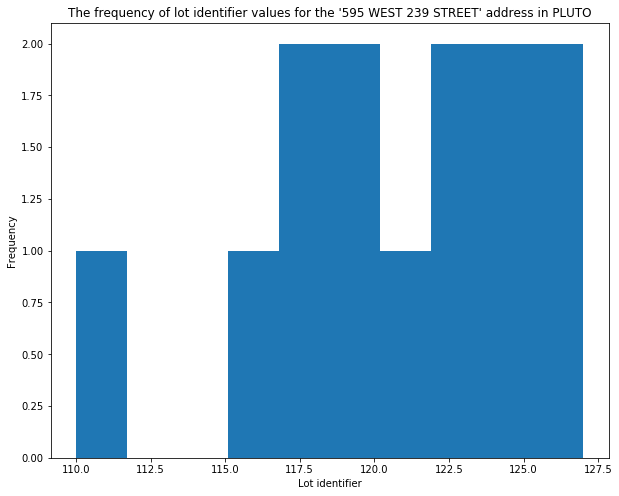

In [24]:
bx_df[bx_df.Address == '595 WEST 239 STREET'].Lot.plot(kind = 'hist', figsize = (10,8))
plt.xlabel('Lot identifier')
plt.title('The frequency of lot identifier values for the \'595 WEST 239 STREET\' address in PLUTO')

It is at the moment hard to judge the reason for the lot duplications and it requires a more thorough investigation. To solve this last problem for now we suggest simply removing all the 'Address' and 'ZipCode' pairs that have duplicate entries in the PLUTO data set.

In [25]:
print('The number of PLUTO entries before removing duplicates: ', bx_df.shape[0])

# First count the distinct ZipCode-Address groups
occur_cnt = bx_df.groupby(['ZipCode','Address']).size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.reset_index(level=0, inplace = True)

# Rename the counts column
occur_cnt.rename(columns={0:'Count'}, inplace = True)

# Join the data into the original table
bx_df_tmp = pd.merge(bx_df, occur_cnt, left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

# Only keep the Address - ZipCode pairs that occur once
rows_index = bx_df_tmp[bx_df_tmp['Count'] > 1].index
bx_df = bx_df_tmp.drop(rows_index, axis = 0)

# Drop the counts columns is it will not be needed and remove the temporary object
bx_df = bx_df.drop('Count', axis = 1)
bx_df_tmp = []

print('The number of PLUTO entries after removing duplicates: ', bx_df.shape[0])

The number of PLUTO entries before removing duplicates:  86591
The number of PLUTO entries after removing duplicates:  85788


Notice that the number of removed rows is marginal, i.e. is about `100 - (85788 * 100)/86591 = 0.92`%

# Combining 311 and PLUTO data sets

In this section we shall join the cleaned 311 and PLUTO data sets to form a single data frame, we shall do it by performing an inner joint on the 311 and PLUTO data frames. The goint will be done by *'Address'* and *'ZipCode'* columns. This way we will only get the complaints that are marched with the PLUTO tax lot. This approach solves the three yet unresolved issues with the PLUTO data set mentioned in the previous section by ignoring the complaints that could not be matched with the tax lots because of the missing house numbers.

In [26]:
print('The number of selected complaints from the 311 data set:', dhp_df.shape[0])
dhp_bx_df = pd.merge(bx_df, dhp_df, how='inner', left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])
print('The resulting number of rows', dhp_bx_df.shape[0])

The number of selected complaints from the 311 data set: 1615055
The resulting number of rows 1284430


As one can see the inner joint has reduced our data quite significantly, i.e. by about `100 - (1284430 * 100) / 1615055 = 20.47`%. However, this is the price we have to pay unless we do a more thorough pre-porocessing of the PLUTO data set. Let us now see if there are any Na/NaN values present in the resulting joint data frame:

In [27]:
dhp_bx_df.isna().describe()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,Type
count,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,...,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,...,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430,1284430


According to the table above there are no Na/NaN values present so we can proceed with analyzing the dependency of the 'HEAT/HOT WATER' comlaints reported in 'BRONX' from any particular house characteristics.

# House characteristics dependency

Please note that, the number of house properties (features) that is selected is currently rather large:

In [28]:
NUM_FEATURES = (dhp_bx_df.shape[1] - len(['Lot', 'Address', 'ZipCode', 'Type']))
print('The number of selected features is:', NUM_FEATURES)

The number of selected features is: 17


We do not consider *'Lot'*, *'Address'*, *'ZipCode'*, and *'Type'* as the former two were used to join the 311 and PLUTO data sets and are not directly related to house properties. The latter is the target variable, i.e. the one that shall depend on the house properties.

It does not seem that the *'Lot'*, *'Address'* and *'ZipCode'* columns will be needed so let us drop them:

In [29]:
dhp_bx_df.drop(columns = ['Lot', 'Address', 'ZipCode'], inplace = True)
display(dhp_bx_df.head())

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord,Type
0,12500,85.0,5.0,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,HEAT/HOT WATER
1,12500,85.0,5.0,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,HEAT/HOT WATER
2,12500,85.0,5.0,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,HEAT/HOT WATER
3,12500,85.0,5.0,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,HEAT/HOT WATER
4,12500,85.0,5.0,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,HEAT/HOT WATER


Among the remaining columns all are numerical except for the target one (*'Type'*):

In [30]:
display(dhp_bx_df.dtypes)

BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
YCoord        float64
XCoord        float64
Type           object
dtype: object

Let us not re-formulate the original question:

> Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

An obsious, but faulty, approach to answering this question would be to select only the 'HEAT/HOT WATER' comlaints in 'BRONX' and then for each of the house features check on the value fistribution and or attempt to see if there are any large clusters defined by the house feature ranges that one can then say are influencing 'causing' the 'HEAT/HOT WATER' comlaint. This however would be a bad approach as it may be so that the identified hous properties are just common to all houses in 'BRONX' and are thus commonly present in all houses of most other complain types.

Therefore the approach we shall take is to be more general. We shall consider the complain type as the target variable we are to predict from the available house features. Then we can perform several type of analysis to identify the features that are most significant for predicting the complain types. These exact features will be then the ones that determine relationship of the complain type, and the 'HEAT/HOT WATER' comlaints in particular, with the house features.

In the following we will perform the three types of analysis to identify such features:
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix

Before the methods will be applied we shall do some preprocessing of the data set and after the analysis will be done we will draw the conclusions on the types of house features highly related to the 'HEAT/HOT WATER' comlaints.

## Pre-processing

In order to be able to apply the aforementioned feature analysis methond one needs to convert the target variable from string to numeric. There is a number of ways to do that, for exampe by explicit mapping, e.g.:

```
type_mapping = {k: v for v, k in enumerate(dhp_bx_df.Type.unique())}
dhp_bx_df['TypeCode'] = dhp_bx_df.Type.map(type_mapping)
```

We will however use the `LabelEncoder` class available in the `sklearn.preprocessing` package:

In [31]:
# Create and fit the encoder
type_encoder = LabelEncoder()
type_encoder.fit(dhp_bx_df.Type)
print('The identified classes are:', type_encoder.classes_)

The identified classes are: ['AGENCY' 'APPLIANCE' 'CONSTRUCTION' 'DOOR/WINDOW' 'ELECTRIC' 'ELEVATOR'
 'FLOORING/STAIRS' 'GENERAL' 'GENERAL CONSTRUCTION' 'HEAT/HOT WATER'
 'NONCONST' 'OUTSIDE BUILDING' 'PAINT - PLASTER' 'PAINT/PLASTER'
 'PLUMBING' 'SAFETY' 'STRUCTURAL' 'UNSANITARY CONDITION' 'WATER LEAK']


In [32]:
# Encode the Type column, and drop the original column
dhp_bx_df['TypeCode'] = type_encoder.transform(dhp_bx_df.Type)
print(dhp_bx_df[['Type', 'TypeCode']])
dhp_bx_df.drop(columns = ['Type'], inplace = True)

                         Type  TypeCode
0              HEAT/HOT WATER         9
1              HEAT/HOT WATER         9
2              HEAT/HOT WATER         9
3              HEAT/HOT WATER         9
4              HEAT/HOT WATER         9
...                       ...       ...
1284425              PLUMBING        14
1284426              PLUMBING        14
1284427              PLUMBING        14
1284428  GENERAL CONSTRUCTION         8
1284429  GENERAL CONSTRUCTION         8

[1284430 rows x 2 columns]


Let us now check on the column types to see if we are ready for the subsequent analysis:

In [33]:
dhp_bx_df.dtypes

BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
YCoord        float64
XCoord        float64
TypeCode        int64
dtype: object

All columns have numeric values so we could proceed. Whowever, in order to improve the analysis we should scale the data, for this we can use the `StandardScaler` from the `sklearn.preprocessing` package. By this step the original data set:

In [34]:
display(dhp_bx_df)

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord,TypeCode
0,12500,85.0,5.00,5.0,6.5,2500,100.00,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,9
1,12500,85.0,5.00,5.0,6.5,2500,100.00,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,9
2,12500,85.0,5.00,5.0,6.5,2500,100.00,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,9
3,12500,85.0,5.00,5.0,6.5,2500,100.00,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,9
4,12500,85.0,5.00,5.0,6.5,2500,100.00,1,5.0,0,12500,6.02,0,1931,2001,232033.0,1006299.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284425,150700,74.0,3.32,0.0,2.0,45375,152.25,1,7.0,0,139200,0.90,0,1954,0,268922.0,1010458.0,14
1284426,150700,74.0,3.32,0.0,2.0,45375,152.25,1,7.0,0,139200,0.90,0,1954,0,268922.0,1010458.0,14
1284427,150700,74.0,3.32,0.0,2.0,45375,152.25,1,7.0,0,139200,0.90,0,1954,0,268922.0,1010458.0,14
1284428,150700,74.0,3.32,0.0,2.0,45375,152.25,1,7.0,0,139200,0.90,0,1954,0,268922.0,1010458.0,8


Gets transformedin a scaled `NumPy` matrix:

In [35]:
scaler = StandardScaler()
dhp_bx_mtx = dhp_bx_df.values.astype(float)
dhp_bx_mtx = scaler.fit(dhp_bx_mtx).transform(dhp_bx_mtx)
display(dhp_bx_mtx)
print('Shape:', dhp_bx_mtx.shape)

array([[-0.56057136, -0.11228068,  0.4821303 , ..., -2.18905644,
        -1.26778339, -0.30739796],
       [-0.56057136, -0.11228068,  0.4821303 , ..., -2.18905644,
        -1.26778339, -0.30739796],
       [-0.56057136, -0.11228068,  0.4821303 , ..., -2.18905644,
        -1.26778339, -0.30739796],
       ...,
       [ 1.49175946, -0.42108548, -0.12175135, ...,  2.56822272,
        -0.61432324,  0.95593239],
       [ 1.49175946, -0.42108548, -0.12175135, ...,  2.56822272,
        -0.61432324, -0.56006403],
       [ 1.49175946, -0.42108548, -0.12175135, ...,  2.56822272,
        -0.61432324, -0.56006403]])

Shape: (1284430, 18)


Note that, normally when building a prediction model for a classification problem that we have the target column is not scaled. In this case we are not going to do prediction, and thus the target variable may be altered. However some of the classification methods that we will use, will require a discrete-valued target. Therefore below we define the X and Y vectors as follows:

In [36]:
# First let us select the training data
X_train = dhp_bx_mtx[:,0:NUM_FEATURES]  #independent columns
print('X_train shape', X_train.shape )

FEATURE_NAMES = dhp_bx_df.columns[range(0, NUM_FEATURES)]

# For the classification task we use the non-scaled discrete value
Y_train = dhp_bx_df.loc[:,'TypeCode'].values
print('Y_train shape', Y_train.shape )

X_train shape (1284430, 17)
Y_train shape (1284430,)


The scaled target will be used for the correlation analysis.

## Univariate Selection
Here we shall consider the `SelectKBest` and `mutual_info_classif` from the `sklearn.feature_selection` package.
We prefer `mutual_info_classif` here over other classifiers because it relies on computation of feature probability distribution which is usually done by using non-parametric methods without any major assumptions.

Let us now compute the top 5 scoring features:

In [37]:
# Create the selector
selector = SelectKBest(mutual_info_classif, k = 'all')
# Train on the train set
selector.fit(X_train, Y_train)

SelectKBest(k='all', score_func=<function mutual_info_classif at 0x1267d40d0>)

In [38]:
# Create the score results data frame 
us_scores_df = pd.DataFrame({ 'feature' : FEATURE_NAMES,
                              'score'   : selector.scores_})
us_scores_df = us_scores_df.set_index('feature')
us_scores_df.sort_values(by = 'score', ascending = False, inplace = True)
display(us_scores_df.head())

,score
feature,
YCoord,0.230422
XCoord,0.224100
BldgArea,0.176178
ResArea,0.173030
LotArea,0.139117


As one can see the top 5 scoring features are:

In [39]:
us_top_5 = us_scores_df.index[0:5].to_list()
display(us_top_5)

['YCoord', 'XCoord', 'BldgArea', 'ResArea', 'LotArea']

 Let us also plot the score values:

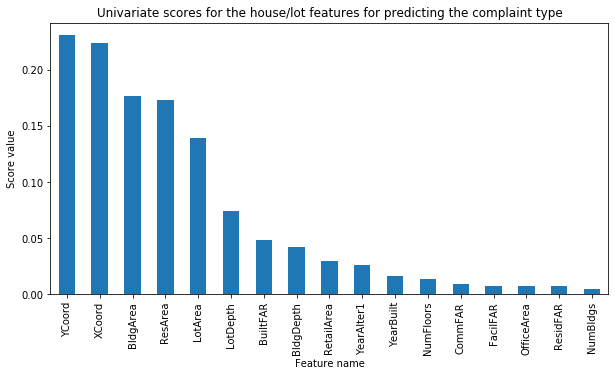

In [40]:
us_scores_df['score'].plot(kind='bar', figsize=(10,5))
plt.title('Univariate scores for the house/lot features for predicting the complaint type')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

## Feature Importance

The feature importance of each feature of a dataset can be also obtained by using the feature importance property of a trained model. The higher the score more important or relevant is the feature towards your output variable.

In [41]:
# Create the Classifier
etc_model = ExtraTreesClassifier()
# Train on the train set
etc_model.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [42]:
# Create the score results data frame 
etc_scores_df = pd.DataFrame({ 'feature' : FEATURE_NAMES,
                               'score'   : etc_model.feature_importances_})
etc_scores_df = etc_scores_df.set_index('feature')
etc_scores_df.sort_values(by = 'score', ascending = False, inplace = True)
display(etc_scores_df.head())

,score
feature,
YCoord,0.129705
XCoord,0.122599
BuiltFAR,0.086973
BldgArea,0.083746
ResArea,0.083203


As one can see the top 5 ExtraTreesClassifier scoring features are:

In [43]:
etc_top_5 = etc_scores_df.index[0:5].to_list()
display(etc_top_5)

['YCoord', 'XCoord', 'BuiltFAR', 'BldgArea', 'ResArea']

Let us also plot the score values:

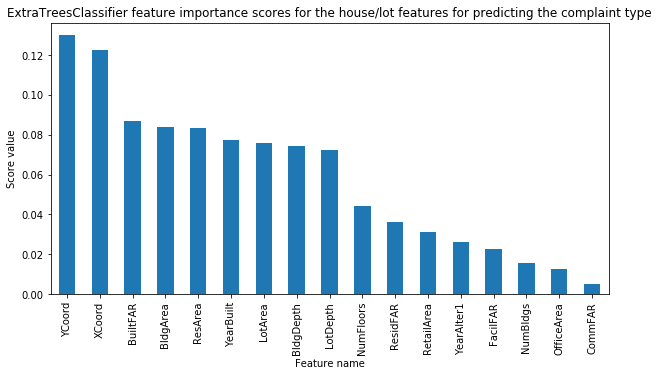

In [44]:
etc_scores_df['score'].plot(kind='bar', figsize=(10,5))
plt.title('ExtraTreesClassifier feature importance scores for the house/lot features for predicting the complaint type')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

## Correlation Matrix

Correlation states how the features are related to each other and/or the target variable. 

Let us now build the correlation matrix and visualize it first:

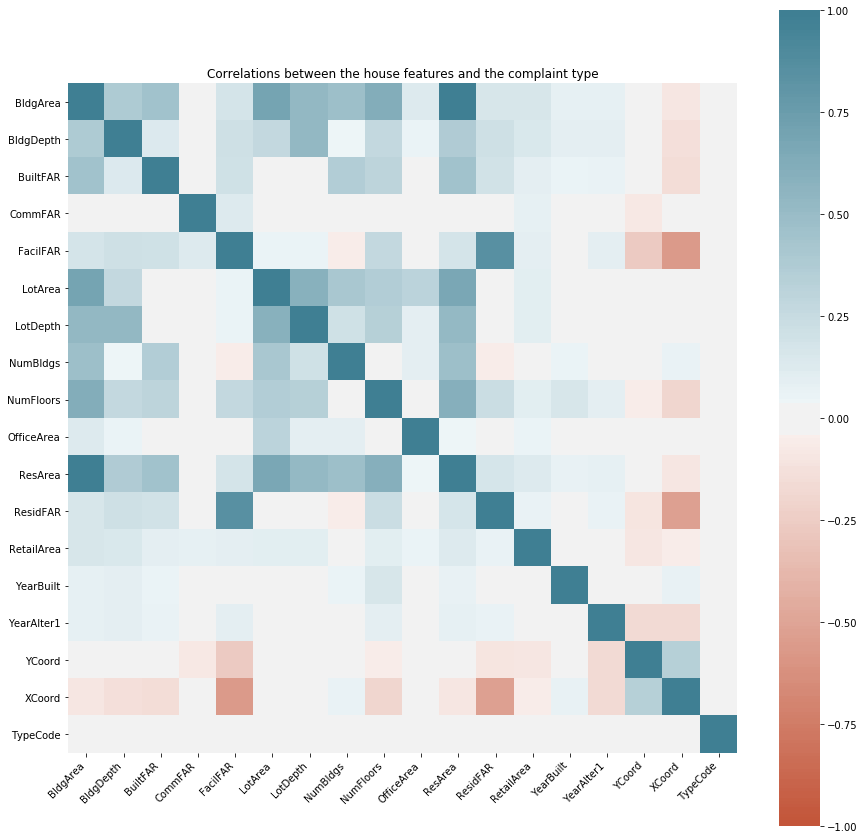

In [45]:
dhp_bx_corr_df = dhp_bx_df.corr()

plt.figure(figsize=(15,15))
plt.title('Correlations between the house features and the complaint type')
ax = sns.heatmap(
    dhp_bx_corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

As one can see there is a number of strongly positively and negatively correlated features. This means that if we are to build a prediction model for the complain type the number of features to be used is likely to be significantly reducible. However, as indicated by the *'TypeCode'* columns and rows most of the features are very weakly correlated with the target variable:

In [46]:
display(dhp_bx_corr_df['TypeCode'])

BldgArea      0.000833
BldgDepth     0.000947
BuiltFAR      0.002488
CommFAR       0.001751
FacilFAR      0.009468
LotArea       0.000636
LotDepth     -0.006216
NumBldgs     -0.003604
NumFloors     0.003735
OfficeArea   -0.001632
ResArea       0.001037
ResidFAR      0.009881
RetailArea   -0.000102
YearBuilt    -0.005541
YearAlter1   -0.000081
YCoord       -0.009745
XCoord       -0.009567
TypeCode      1.000000
Name: TypeCode, dtype: float64

Nether the less let us compute the absolute correlation values for features and the *'TypeCode'*:

In [47]:
NUM_COLS = dhp_bx_corr_df.shape[1]
corr_scores_df = dhp_bx_corr_df['TypeCode'].abs().sort_values(ascending=False)[1:NUM_COLS].to_frame()
corr_scores_df.rename({'TypeCode' : 'abs_corr'}, axis = 1, inplace = True)
corr_scores_df.head()

,abs_corr
ResidFAR,0.009881
YCoord,0.009745
XCoord,0.009567
FacilFAR,0.009468
LotDepth,0.006216


The top 5 correlated features with the target variable are:

In [48]:
corr_top_5 = corr_scores_df.index[0:5].to_list()
corr_top_5

['ResidFAR', 'YCoord', 'XCoord', 'FacilFAR', 'LotDepth']

## Analysis conclusions

Above we have performed three different types of feature importance analysis:

1. Univariate Selection, with:
   1. Mutual Information Classifier
2. Feature Importance, with:
   1. Extra Trees Classifier
   2. Decision Tree Classifier
3. Correlation Matrix

First let us summarize the top 5 significant features found by each of the approaches:

In [49]:
fi_res_df = pd.DataFrame({'Univariate Selection' : us_top_5, 
                          'Feature Importance'   : etc_top_5, 
                          'Correlation Matrix'   : corr_top_5})
fi_res_df.index.name = 'Priority'
display(fi_res_df)

,Univariate Selection,Feature Importance,Correlation Matrix
Priority,,,
0,YCoord,YCoord,ResidFAR
1,XCoord,XCoord,YCoord
2,BldgArea,BuiltFAR,XCoord
3,ResArea,BldgArea,FacilFAR
4,LotArea,ResArea,LotDepth


The common features identified by all the three methods are:

In [50]:
imp_features = set(us_top_5) & set(etc_top_5) & set(corr_top_5)
print('Commonly identified important features are: ', imp_features)

Commonly identified important features are:  {'YCoord', 'XCoord'}


It is quite interesting that the two coordinate components were found significant by most of the methods. We could go further into the analysis on how much of the complaint type variability do these two features explain, but since there are just two of them we may as well plot the data to see how the complaint type clustering looks like:

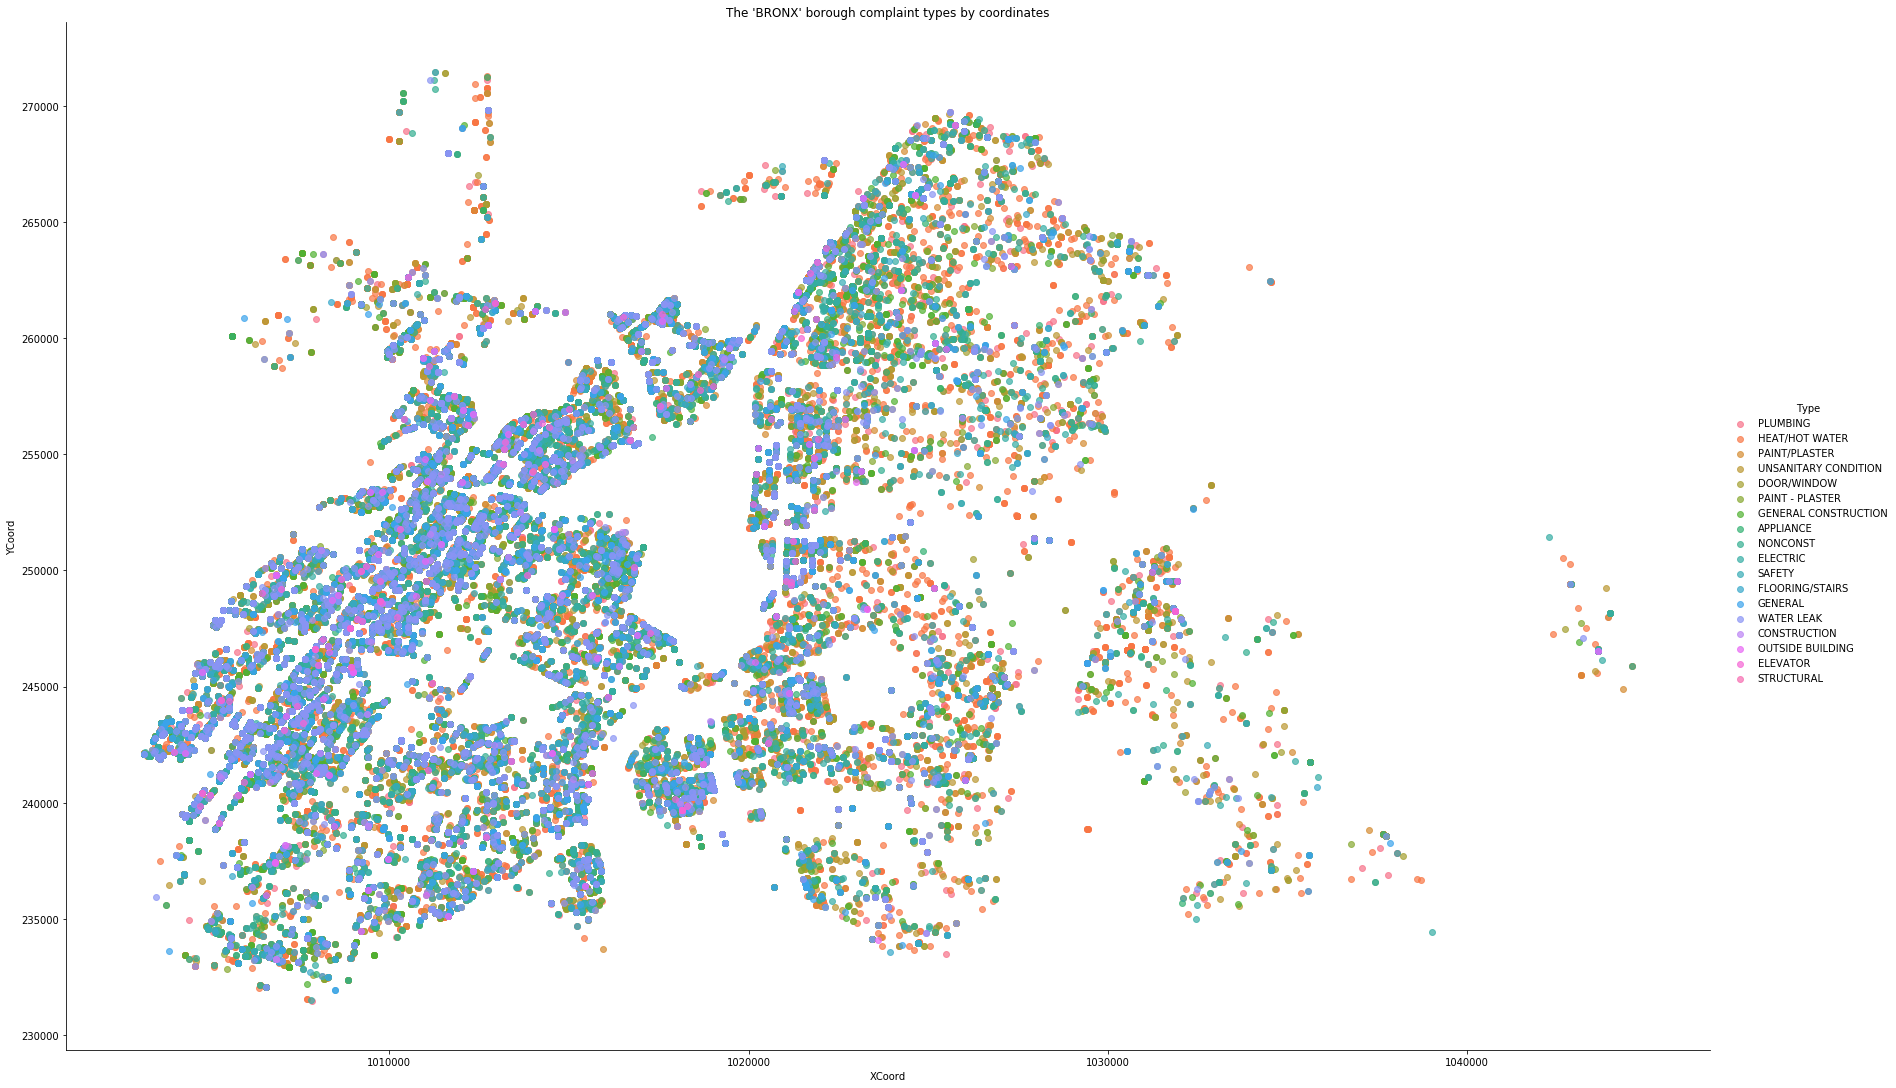

In [51]:
# De-code the type code
dhp_bx_df['Type'] = type_encoder.inverse_transform(dhp_bx_df['TypeCode'])

def plot_comp_coord(df):
    # Plot the values
    fg = seaborn.FacetGrid(data = df, hue = 'Type', aspect=1.61, height = 15)
    fg.map(plt.scatter, 'XCoord', 'YCoord', alpha = 0.7).add_legend()

    plt.title('The \'BRONX\' borough complaint types by coordinates')
    plt.xlabel('XCoord')
    plt.ylabel('YCoord')

    plt.show()
    plt.close()
    
# Take a sub-sample for speed and less crouded data
plot_comp_coord(dhp_bx_df.sample(100000))

Remarcably enough, the plot does not show much of clastorization. The complaints of different seem to be rather evenly spread accross the 'BRONX' borough. Let us reduce the data by separately looking into the top 3 complaint types, as found when answering to Question1: `'HEAT/HOT WATER', 'PLUMBING', 'GENERAL CONSTRUCTION'`

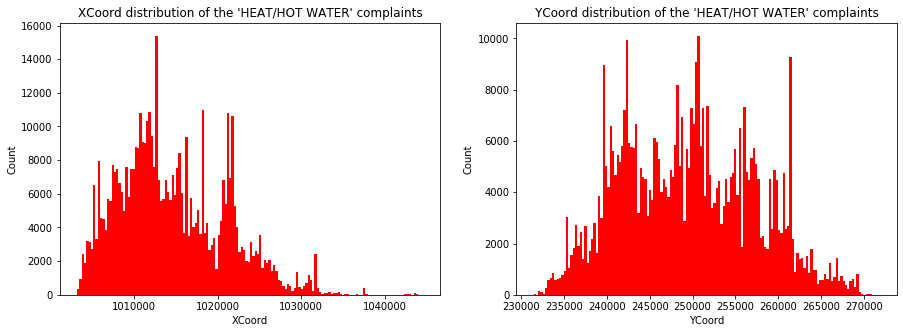

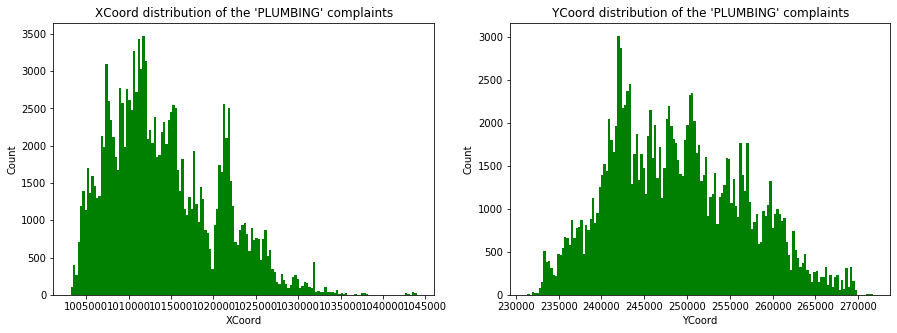

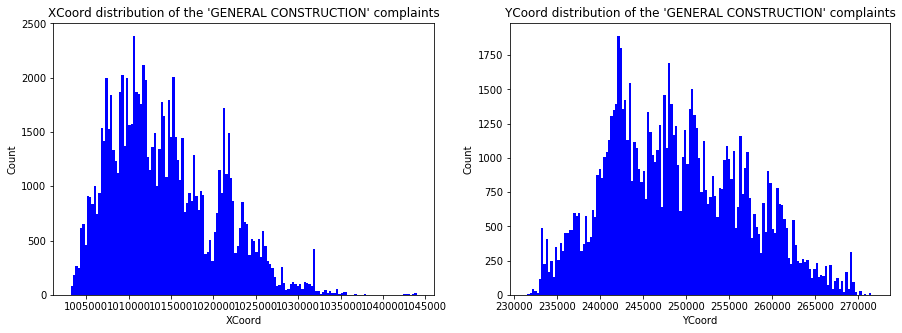

In [52]:
# This function will plot the distribution of the given complaint type in one coordinate
def plot_comp_crd_distr(df, fig, idx, color, coord, comp_id, bins) :
    ax = fig.add_subplot(1, 2, idx)
    ax.hist(df[coord], bins = bins, facecolor = color)
    ax.set_xlabel(coord)
    ax.set_ylabel('Count')
    ax.set_title(coord + ' distribution of the \'' + comp_id + '\' complaints')

# This function will plot the distribution of the given complaint type in X and Y coordinates
def plot_comp_distr(df, color, comp_id, bins = 150):
    fig = plt.figure(figsize=(15, 5))
    sel_df = df[df['Type'] == comp_id]
    plot_comp_crd_distr(sel_df, fig, 1, color, 'XCoord', comp_id, bins)
    plot_comp_crd_distr(sel_df, fig, 2, color, 'YCoord', comp_id, bins)
    plt.show()
    plt.close()
    
plot_comp_distr(dhp_bx_df, 'r', 'HEAT/HOT WATER')
plot_comp_distr(dhp_bx_df, 'g', 'PLUMBING')
plot_comp_distr(dhp_bx_df, 'b', 'GENERAL CONSTRUCTION')

It is pretty apparent now that even though the distributions are different they are still very similar in shape. This means that it is likely not enough to use just these two features for predictiong the complaint type. Yet, the *'XCoord'* and *'YCoord'* columns were indicated as significant for predicitons by all the methods used. This probabli means that in general, even though being most predictive, the prediction power of these features is very low. This is to be verified for example by evaluating the predictions of a trained model, but we see this outside the scope of this  question.

A better solution to the question at hand would be using the Principle Component Analysis that would provide the necessary data transformation to get the minimum amount of predictors explaining the complaint type in a different spae. This is however outide the analysis requested for the question at hand as the features in the transformed space will not have any meaningfull interpretation. Thus, withot checking on the percentage of the target value explainability by the found important features, I would recommend using the top 5 features that are recommended at least by the two of the three used methods, namely:

In [70]:
imp_counts = []
imp_counts.extend(us_top_5)
imp_counts.extend(etc_top_5)
imp_counts.extend(corr_top_5)
imp_cnd_df = pd.DataFrame({'Features' : imp_counts})
imp_fe_cnts = imp_cnd_df.Features.value_counts()
imp_fe_cnts

XCoord      3
YCoord      3
BldgArea    2
ResArea     2
LotDepth    1
LotArea     1
FacilFAR    1
ResidFAR    1
BuiltFAR    1
Name: Features, dtype: int64

Using *'BldgArea'* and *'ResArea'* in combination is likely to give more predictive power. Let us investigate now if these two columns do allow for data clusterization. This time we shall do it by means of analyzing the box plots:

In [59]:
tba_df = dhp_bx_df[['Type', 'BldgArea']]
tba_df = pd.pivot(tba_df, columns = 'Type', values = 'BldgArea')

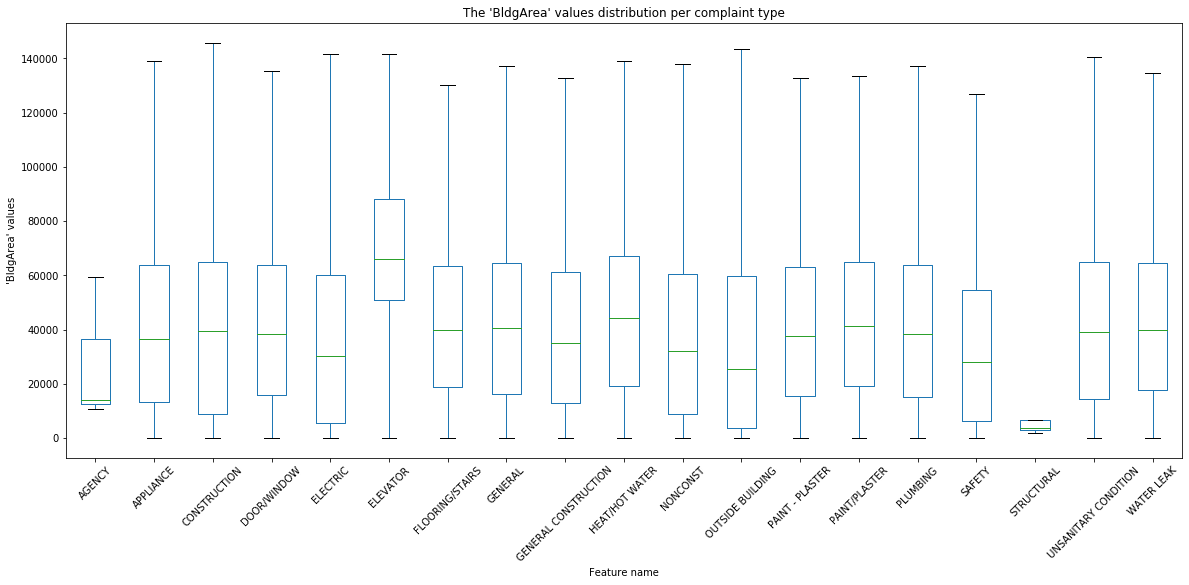

In [68]:
tba_df.plot(kind = 'box', figsize= (20, 8), showfliers = False)
plt.xticks(rotation=45)
plt.title('The \'BldgArea\' values distribution per complaint type')
plt.ylabel('\'BldgArea\' values')
plt.xlabel('Feature name')
plt.show()
plt.close()

According to the box plot for the *'BldgArea'* feature values distribution per complain type above one can see that except for the *'ELEATOR'*, *'STRUCTURAL'* and perhaps *'AGENCY'* complaint types the distributions of the *'BldgArea'* feature values for the other comlaint types are very similar.

Let us now perform the same analysis for the *'ResArea'* feature:

In [67]:
tra_df = dhp_bx_df[['Type', 'ResArea']]
tra_df = pd.pivot(tra_df, columns = 'Type', values = 'ResArea')

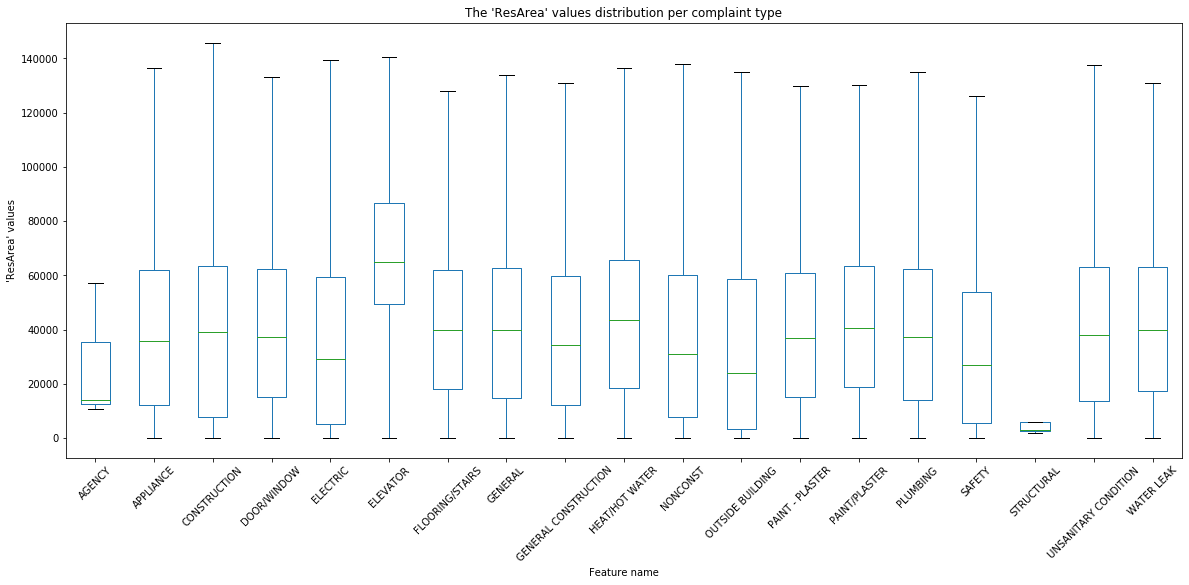

In [69]:
tra_df.plot(kind = 'box', figsize= (20, 8), showfliers = False)
plt.xticks(rotation=45)
plt.title('The \'ResArea\' values distribution per complaint type')
plt.ylabel('\'ResArea\' values')
plt.xlabel('Feature name')
plt.show()
plt.close()

The results for the *'BldgArea'* plot above are the same as those for the *'BldgArea'* one. The conclusion for these two features is thus also that their predictive value, despite being indicated to have higher scores than many other features is likely to be weak. However, the actual quantification of the predictive power is to be done by means of beilding, training and testing the prediction model, which is outside the scope of this question.

The overall conclusion for the analysis is that the four most significant predictors: 

In [74]:
print(imp_fe_cnts.index[imp_fe_cnts >= 2].to_list())

['XCoord', 'YCoord', 'BldgArea', 'ResArea']


indiated by the three different types of analysis above are likely not to have a good predictive pover as the visual inspection of the complaint types clustering for these features did not reveal any significant dependencies.

# Conclusions